# Homework I

Joana Peixinho (ist1103335) & Miguel Fernandes (ist1103573)

## I. Pen and Paper [11v]



### 1) [6v] Perform one epoch of the EM clustering algorithm and determine the new parameters. 
Hint: we suggest you to use numpy and scipy, however disclose the intermediary results step by step

In [1]:
import numpy as np
from scipy.stats import multivariate_normal

observations = np.array([
    [1, 0.6, 0.1],
    [0, -0.4, 0.8],
    [0, 0.2, 0.5],
    [1, 0.4, -0.1]
])

# Number of clusters
K = 2


pi = np.array([0.5, 0.5])
p = np.array([0.3, 0.7])
mu = np.array([[1, 1], [0, 0]])
cov = np.array([[[2, 0.5], [0.5, 2]], [[1.5, 1], [1, 1.5]]])

updated_pi = np.array([0.0, 0.0])
updated_p = np.array([0.0, 0.0])
updated_mu = np.array([[0.0, 0.0], [0.0, 0.0]])
updated_cov = np.array([[[0.0, 0.0], [0.0, 0.0]], [[0.0, 0.0], [0.0, 0.0]]])
# EM Clustering
num_iterations = 1


for _ in range(num_iterations):
    # Expectation step
    cluster_probabilities = np.zeros((len(observations), K))
    for k in range(K):
        cluster_probabilities[:, k] = pi[k] * multivariate_normal.pdf(observations[:, 1:], mean=mu[k], cov=cov[k])
        #To account for the Bernoulli distribution of y1
        for i in range(len(observations)): 
            if observations[i, 0] == 0:
                cluster_probabilities[i, k] *= (1 - p[k])
            else:  
                cluster_probabilities[i, k] *= p[k]
    
    print("Posteriori probabilities, before normalization:")
    print(cluster_probabilities)
    
    cluster_probabilities /= cluster_probabilities.sum(axis=1)[:, np.newaxis]
    
    print("Posteriori probabilities, after normalization:")
    print(cluster_probabilities)

    # Maximization step
    Nk = cluster_probabilities.sum(axis=0)
    updated_pi = Nk / len(observations)
    updated_p = cluster_probabilities.T.dot(observations[:, 0]) / Nk
 
 
    for k in range(K):
        updated_mu[k] = cluster_probabilities[:, k].dot(observations[:, 1:])
    updated_mu = updated_mu / Nk[:, np.newaxis]
    

    for k in range(K):
        x_minus_mu = observations[:, 1:] - updated_mu[k]
        updated_cov[k] = np.dot(x_minus_mu.T, (x_minus_mu * cluster_probabilities[:, k][:, np.newaxis])) / Nk[k]


print("Priors (Pi) atualizados:")
print(updated_pi)
print("Probabilidades (p) atualizadas:")
print(updated_p)
print("Médias mu_1 e mu_2 atualizadas:")
print(updated_mu)
print("Matrizes de Covariância atualizadas:")
print(updated_cov)


Posteriori probabilities, before normalization:
[[0.00998629 0.04186643]
 [0.01751711 0.01022859]
 [0.02393108 0.01943716]
 [0.00885705 0.04357503]]
Posteriori probabilities, after normalization:
[[0.19258959 0.80741041]
 [0.63134512 0.36865488]
 [0.55181128 0.44818872]
 [0.16892423 0.83107577]]
Priors (Pi) atualizados:
[0.38616755 0.61383245]
Probabilidades (p) atualizadas:
[0.23403948 0.66731817]
Médias mu_1 e mu_2 atualizadas:
[[0.026509   0.50712978]
 [0.30914476 0.2104205 ]]
Matrizes de Covariância atualizadas:
[[[ 0.14136501 -0.10540546]
  [-0.10540546  0.0960526 ]]

 [[ 0.10829305 -0.08865175]
  [-0.08865175  0.1041233 ]]]


### 2)  [2v] Given the new observation, 𝐱𝑛𝑒𝑤 , determine the cluster memberships (posteriors).

In [2]:
import numpy as np
from scipy.stats import multivariate_normal

# New observation
x_new = np.array([1, 0.3, 0.7])

# Expectation step
cluster_probabilities_x_new = np.zeros(K)

for k in range(K):
    cluster_probabilities_x_new[k] = updated_pi[k] * multivariate_normal.pdf(x_new[1:], mean=updated_mu[k], cov=updated_cov[k])
    if x_new[0] == 0:
        cluster_probabilities_x_new[k] *= (1 - updated_p[k])
    else:  
        cluster_probabilities_x_new[k] *= updated_p[k]

cluster_probabilities_x_new /= cluster_probabilities_x_new.sum()

print("Cluster Probabilities for the new observation:")
print(cluster_probabilities_x_new)


Cluster Probabilities for the new observation:
[0.08028951 0.91971049]


### 3) [2.5v] Performing a hard assignment of observations to clusters under a ML assumption, identify the silhouette of the larger cluster under a Manhattan distance

In [10]:

from scipy.stats import multivariate_normal
from sklearn.metrics import silhouette_samples
from sklearn.metrics.pairwise import pairwise_distances
import numpy as np

# Calculate likelihoods
updated_likelihoods = np.zeros((len(observations), K))
updated_class_observations = observations

for k in range(K):
    updated_likelihoods[:, k] = multivariate_normal.pdf(observations[:, 1:], mean=updated_mu[k], cov=updated_cov[k])
    
    for i in range(len(observations)): 
        if observations[i, 0] == 0:
            updated_likelihoods[i, k] *= (1 - updated_p[k])
        else:  
            updated_likelihoods[i, k] *= updated_p[k]

# Update class of observations (the cluster they are in)
for i in range(len(updated_class_observations)):
    if updated_likelihoods[i][0] >= updated_likelihoods[i][1]:
        updated_class_observations[i][0] = 0

# Calculate pairwise distances using Manhattan distance
pairwise_manhattan_distances = pairwise_distances(observations, metric="manhattan")

# Calculate silhouette scores
silhouette_scores = silhouette_samples(pairwise_manhattan_distances, updated_class_observations[:, 0], metric="precomputed")

silhouette_scores_cluster_0 = silhouette_scores[updated_class_observations[:, 0] == 0]
silhouette_scores_cluster_1 = silhouette_scores[updated_class_observations[:, 0] == 1]


#average silhouette score for cluster 0
print("Average silhouette score for cluster 0:")
print(silhouette_scores_cluster_0.mean())

#average silhouette score for cluster 1
print("Average silhouette score for cluster 1:")
print(silhouette_scores_cluster_1.mean())


# Print likelihoods, observations in each cluster, and silhouette scores
print("Likelihoods for each observation being in each cluster:")
print(updated_likelihoods)



Average silhouette score for cluster 0:
0.5833333333333333
Average silhouette score for cluster 1:
0.8222222222222223
Likelihoods for each observation being in each cluster:
[[0.23147434 0.94954252]
 [1.26633248 0.08873672]
 [1.4381104  0.4541745 ]
 [0.02076523 0.72331198]]


### 4) [0.5v] Knowing the purity of the clustering solution is 0.75, identify the number of possible classes (ground truth).


## Programming [9v]

Recall the `column_diagnosis.arff` dataset from previous homeworks. For the following exercises,
normalize the data using sklearn’s MinMaxScaler 

In [4]:
#Load the data

import pandas as pd
import numpy as np
from scipy.io.arff import loadarff

# Reading the ARFF file
data = loadarff('column_diagnosis.arff')
df = pd.DataFrame(data[0])
df['class'] = df['class'].str.decode('utf-8')


### 1) 
[4v] Using sklearn, apply k-means clustering fully unsupervisedly on the normalized data with
𝑘 ∈ {2,3,4,5} (random=0 and remaining parameters as default). Assess the silhouette and purity of
the produced solutions.


In [5]:
from sklearn import datasets, metrics, cluster, mixture
from sklearn.preprocessing import MinMaxScaler


k = [2, 3, 4, 5]

def purity_score(y_true, y_pred):
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

X, y = df.drop('class', axis=1), df['class']
X_scaled = MinMaxScaler().fit_transform(X)

for i in k:
    kmeans = cluster.KMeans(n_clusters=i, random_state=0).fit(X_scaled)
    print("K-Means Clustering with k = " + str(i))
    print("Silhouette Score: " + str(metrics.silhouette_score(X_scaled, kmeans.labels_)))
    print("Purity Score: " + str(purity_score(y, kmeans.labels_)))
    print("\n")


/home/joanapeixinho/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/joanapeixinho/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


K-Means Clustering with k = 2
Silhouette Score: 0.36044124340441114
Purity Score: 0.632258064516129


K-Means Clustering with k = 3
Silhouette Score: 0.29579055730002257
Purity Score: 0.667741935483871




/home/joanapeixinho/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/joanapeixinho/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


K-Means Clustering with k = 4
Silhouette Score: 0.27442402122340176
Purity Score: 0.6612903225806451


K-Means Clustering with k = 5
Silhouette Score: 0.23823928397844843
Purity Score: 0.6774193548387096




### 2)
[2v] Consider the application of PCA after the data normalization:
i. Identify the variability explained by the top two principal components.
ii. For each one of these two components, sort the input variables by relevance by
inspecting the absolute weights of the linear projection

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Fit PCA to the normalized data
pca = PCA(svd_solver='full')
pca = pca.fit(X_scaled)

# 2i. Variability explained by the top two principal components
explained_variance_ratio = pca.explained_variance_ratio_
print("Variability explained by the top two principal components: {:.2f}%".format(sum(explained_variance_ratio[:2]) * 100))

# 2ii. Sort input variables by relevance in the top two components
sorted_variables_pc1 = np.argsort(np.abs(pca.components_[0]))[::-1]
sorted_variables_pc2 = np.argsort(np.abs(pca.components_[1]))[::-1]


# List the variables by relevance in the top two components
print("Top variables for PC1:")
for i, var_index in enumerate(sorted_variables_pc1):
    print(f"{i+1}. {df.columns[var_index]}")

print("\nTop variables for PC2:")
for i, var_index in enumerate(sorted_variables_pc2):
    print(f"{i+1}. {df.columns[var_index]}")


Variability explained by the top two principal components: 77.14%
Top variables for PC1:
1. pelvic_incidence
2. lumbar_lordosis_angle
3. pelvic_tilt
4. sacral_slope
5. degree_spondylolisthesis
6. pelvic_radius

Top variables for PC2:
1. pelvic_tilt
2. pelvic_radius
3. sacral_slope
4. pelvic_incidence
5. lumbar_lordosis_angle
6. degree_spondylolisthesis


### 3) 
[2v] Visualize side-by-side the data using: i) the ground diagnoses, and ii) the previously learned
𝑘 = 3 clustering solution. To this end, projected the normalized data onto a 2-dimensional data
space using PCA and then color observations using the reference and cluster annotations

/home/joanapeixinho/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


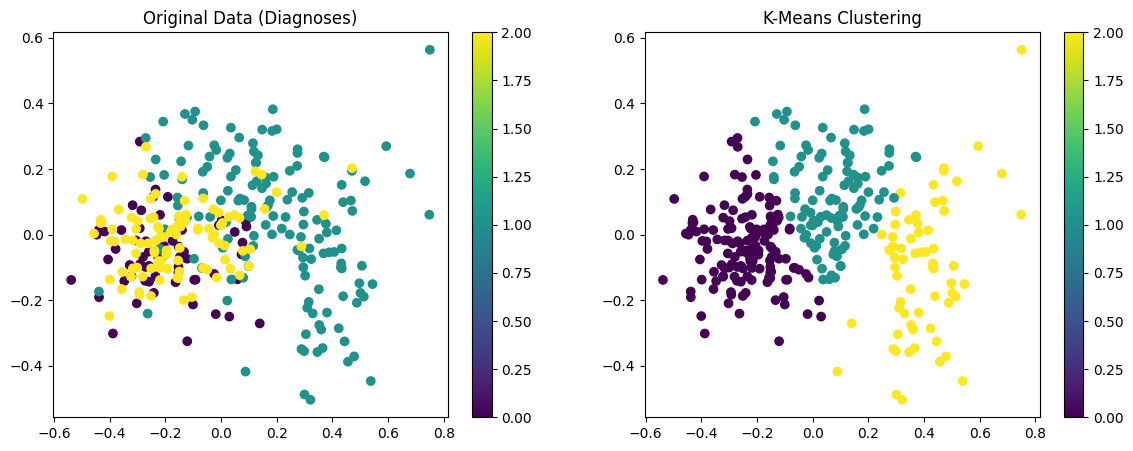

In [7]:
import matplotlib.pyplot as plt

kmeans = cluster.KMeans(n_clusters=3, random_state=0).fit(X_scaled)
#PCA
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
num = [0 if x == 'Hernia' else 1 if x == 'Spondylolisthesis' else 2 for x in y]
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=num, cmap='viridis')
plt.title("Original Data (Diagnoses)")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title("K-Means Clustering")
plt.colorbar()

plt.show()

### 4)
[1v] Considering the results from questions (1) and (3), identify two ways on how clustering can
be used to characterize the population of ill and healthy individuals



Clustering can be used to characterize the population of ill and healthy individuals in two ways:

Identifying Subgroups: Clustering helps identify different subgroups within the ill or healthy populations based on common characteristics. This can help identify the characteristics that are most closely associated with the illness.

Risk Assessment: Clustering can also be used to assess the risk of developing an illness. For example, if a person is in a cluster with many ill people, they may be at higher risk of developing the illness than someone in a cluster with few ill people.